$$
  -\Delta u(x,y) \;=\; f(x,y),
  \qquad (x,y)\in[a,a+L]\times[b,b+L],
$$
$$
a=-1,\quad b=-1,\quad L=2
$$
$$
  u(x,y) = u_E(x,y) \quad\text{en las fronteras } x=a\ \cup\ y=b+L,
  \quad u_E(x,y) = \sin(\pi x)\cos(\pi y).
$$
$$
  \frac{\partial u}{\partial n}(x,y) = q_E(y)\quad\text{en } x=a+L,
  \qquad
  \frac{\partial u}{\partial n}(x,y) = q_S(x)\quad\text{en } y=b,
$$
$$
  q_E(y) = \pi\cos\bigl(\pi(a+L)\bigr)\cos(\pi y),
  \qquad
  q_S(x) = \pi\sin(\pi x)\sin\bigl(\pi b\bigr).
$$
$$
  f(x,y) = 2\pi^2\,\sin(\pi x)\cos(\pi y).
$$

In [77]:
# =============
# CARGA DE LIBRERIAS

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

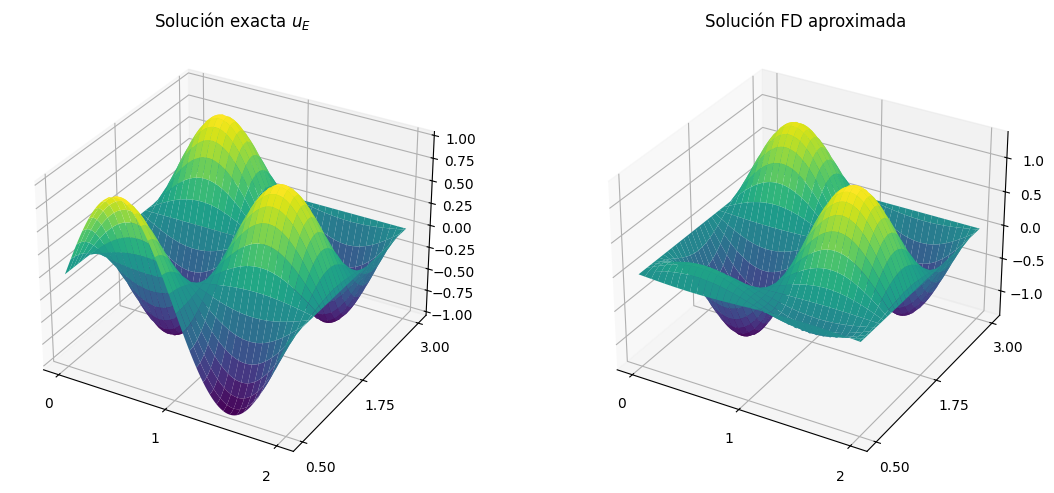

In [78]:
# RESOLUCION MEDIANTE MDF

# Parametros del dominio y malla
a, b, Lx, Ly = 0, 1/2, 2, 5/2
N = 99                        # N+1 subdivisiones por lado
hx = Lx / (N + 1)             # paso uniforme
hy = Ly / (N + 1)             # paso uniforme
x = np.linspace(a, a+Lx, N+2)
y = np.linspace(b, b+Ly, N+2)
X, Y = np.meshgrid(x, y, indexing='ij')  # malla 2D

# Funciones analiticas
def uE(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_source(x, y):
    return 2 * (np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

def qS(x):
    return -np.pi * np.sin(np.pi * x)

# Indices de frontera
xx = X.ravel()
yy = Y.ravel()
nfO = np.where(np.isclose(xx, a))[0]        # oeste (Dirichlet)
nfE = np.where(np.isclose(xx, a+Lx))[0]     # este (Dirichlet)
nfS = np.where(np.isclose(yy, b))[0]        # sur (Neumann)
nfN = np.where(np.isclose(yy, b+Ly))[0]     # norte (Dirichlet)
nfD = np.union1d(nfN, nfO)
nfD = np.union1d(nfD, nfE)                  # Dirichlet combinado

# Vector independiente con penalizacion y Neumann
fV = f_source(xx, yy)
fV[nfS] += 2 * qS(xx[nfS]) / hy
fV[nfD] = uE(xx[nfD], yy[nfD]) * 1e16

# Construccion de la matriz dispersa A
I = sparse.eye(N+2)
E = diags(np.ones(N+1), -1)
D = (2*I - E - E.T).tolil()
D[0,1]   = -2   # ajuste en frontera para Neumann
D[N+1,N] = -2
D = D.tocsr()
A = (sparse.kron(D, I) + sparse.kron(I, D)) / hy**2

# Penalizacion Dirichlet en la diagonal
diagA = A.diagonal().copy()
diagA[nfD] = 1e16
A.setdiag(diagA)

# Resolucion y reconstruccion
sol = spsolve(A.tocsc(), fV)
uA = sol.reshape((N+2, N+2))

# Visualizacion 3D
xticks = [a, a + Lx/2, a + Lx]
yticks = [b, b + Ly/2, b + Ly]

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot_surface(X, Y, uE(X,Y), cmap='viridis', rstride=3, cstride=3)
ax1.set_title('Solución exacta $u_E$')
ax1.set_xticks(xticks); ax1.set_yticks(yticks)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(X, Y, uA, cmap='viridis', rstride=3, cstride=3)
ax2.set_title('Solución FD aproximada')
ax2.set_xticks(xticks); ax2.set_yticks(yticks)

plt.tight_layout()
plt.show()

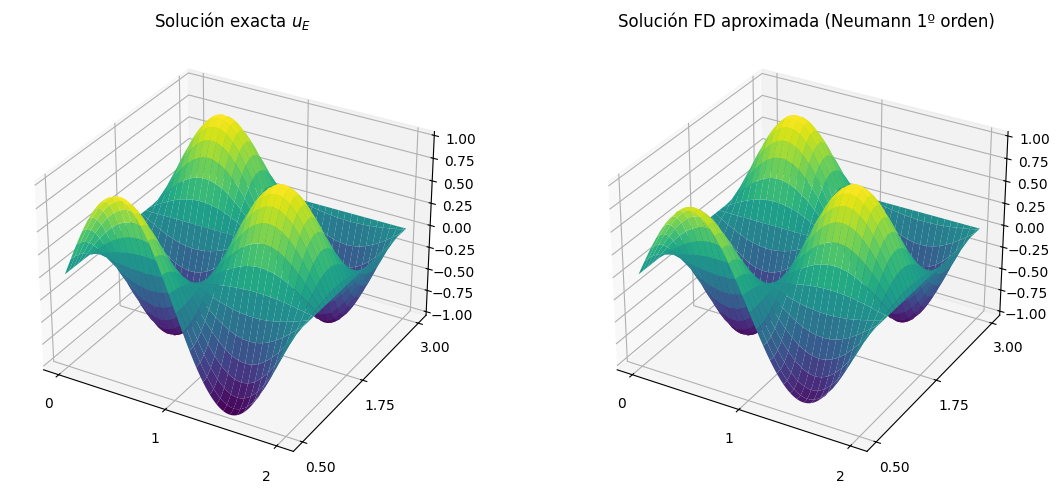

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Parámetros del dominio y malla
a, b = 0, 1/2               # origen
Lx, Ly = 2, 5/2             # dimensiones en x e y
N = 99                      # N+1 subdivisiones ⇒ N+2 nodos
hx = Lx / (N + 1)           # paso en x
hy = Ly / (N + 1)           # paso en y
x = np.linspace(a, a + Lx, N + 2)
y = np.linspace(b, b + Ly, N + 2)
X, Y = np.meshgrid(x, y, indexing='ij')

# Solución exacta y fuente/Neumann
def uE(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_source(x, y):
    return 2 * (np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

def qS(x):
    return -np.pi * np.sin(np.pi * x)

# Índices de frontera (ravel)
xx = X.ravel()
yy = Y.ravel()
nfO = np.where(np.isclose(xx, a))[0]        # oeste: Dirichlet
nfE = np.where(np.isclose(xx, a + Lx))[0]   # este: Dirichlet
nfN = np.where(np.isclose(yy, b + Ly))[0]   # norte: Dirichlet
nfD = np.union1d(np.union1d(nfO, nfE), nfN) # conjunto Dirichlet
nfS = np.where(np.isclose(yy, b))[0]        # sur: Neumann

# Operador 1D en x (segundo orden)
I_x = sparse.eye(N + 2)
e = np.ones(N + 1)
E_x = sparse.diags(e, -1)
D_x = (2 * I_x - E_x - E_x.T).tocsr()

# Operador 1D en y con Neumann de primer orden en j=0
I_y = sparse.eye(N + 2)
E_y = sparse.diags(e, -1)
# Construimos inicialmente el Laplaciano 3‑puntos
D_y = (2 * I_y - E_y - E_y.T).tolil()
# Para j=0 (y=b) sustituimos por forward‑difference de primer orden:
# ∂u/∂y ≈ (u₁ - u₀)/hy = qS  ⇒  fila: (-u₀ + u₁)/hy
# No necesitamos ajustar RHS, pues el PDE usa este operador directo.
D_y[0, :] = 0
D_y[0, 0] = -1
D_y[0, 1] =  1
D_y = D_y.tocsr()

# Montaje de la Laplaciana 2D
A = (sparse.kron(D_x, I_y) / hx**2
   + sparse.kron(I_x, D_y) / hy**2)

# Vector RHS evaluado en la malla interna
fV = f_source(X, Y).ravel()

# Imposición de Dirichlet fuerte por penalización
penalty = 1e16
for idx in nfD:
    A[idx, :] = 0
    A[idx, idx] = penalty
    fV[idx] = penalty * uE(xx[idx], yy[idx])

# Resolución del sistema
sol = spsolve(A.tocsc(), fV)
uA = sol.reshape((N + 2, N + 2))

# Visualización comparativa
xticks = [a, a + Lx/2, a + Lx]
yticks = [b, b + Ly/2, b + Ly]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, uE(X, Y), cmap='viridis', rstride=3, cstride=3)
ax1.set_title('Solución exacta $u_E$')
ax1.set_xticks(xticks); ax1.set_yticks(yticks)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, uA, cmap='viridis', rstride=3, cstride=3)
ax2.set_title('Solución FD aproximada (Neumann 1º orden)')
ax2.set_xticks(xticks); ax2.set_yticks(yticks)

plt.tight_layout()
plt.show()